In [1]:
setwd('data')
list.files()

[1] "prosperLoanData.csv"

In [2]:
# Read data
loans <- read.csv('prosperLoanData.csv')

In [3]:
# Load Libraries
library(plyr)
library(ggplot2)
library(dplyr)
library(stringr)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



## Cleaning Section

In [32]:
loans$LoanStatus <- factor(loans$LoanStatus, levels = c('Cancelled',
                                                          'Defaulted',
                                                          'Chargedoff',
                                                          'Completed',
                                                          'Current',
                                                          'FinalPaymentInProgress',
                                                          'Past Due (1-15 days)',
                                                          'Past Due (16-30 days)',
                                                          'Past Due (31-60 days)',
                                                          'Past Due (61-90 days)',
                                                          'Past Due (91-120 days)',
                                                          'Past Due (>120 days)'
                                                         ))

[1] "Cancelled"              "Defaulted"              "Chargedoff"            
 [4] "Completed"              "Current"                "FinalPaymentInProgress"
 [7] "Past Due (1-15 days)"   "Past Due (16-30 days)"  "Past Due (31-60 days)" 
[10] "Past Due (61-90 days)"  "Past Due (91-120 days)" "Past Due (>120 days)"

Wrote a short function to convert the numeric categories to their values.

In [ ]:
listingToCharacter <- function(numeric.category){
    listing.categories = c("Not Available", "Debt Consolidation", "Home Improvement", "Business",
                       "Personal Loan", "Student Use", "Auto", "Other", "Baby&Adoption","Boat",
                       "Cosmetic Procedure", "Engagement Ring", "Green Loans", "Household Expenses",
                       "Large Purchases", "Medical/Dental", "Motorcycle", "RV", "Taxes", "Vacation",
                       "Wedding Loans")
    return(listing.categories[numeric.category + 1]) 
}

In [ ]:
loans$ListingCategory <- listingToCharacter(loans$ListingCategory..numeric)

## Univariate Exploration

In [4]:
dim(loans)
str(loans)

[1] 113937     81

'data.frame':	113937 obs. of  81 variables:
 $ ListingKey                         : Factor w/ 113066 levels "00003546482094282EF90E5",..: 7180 7193 6647 6669 6686 6689 6699 6706 6687 6687 ...
 $ ListingNumber                      : int  193129 1209647 81716 658116 909464 1074836 750899 768193 1023355 1023355 ...
 $ ListingCreationDate                : Factor w/ 113064 levels "2005-11-09 20:44:28.847000000",..: 14184 111894 6429 64760 85967 100310 72556 74019 97834 97834 ...
 $ CreditGrade                        : Factor w/ 9 levels "","A","AA","B",..: 5 1 8 1 1 1 1 1 1 1 ...
 $ Term                               : int  36 36 36 36 36 60 36 36 36 36 ...
 $ LoanStatus                         : Factor w/ 12 levels "Cancelled","Chargedoff",..: 3 4 3 4 4 4 4 4 4 4 ...
 $ ClosedDate                         : Factor w/ 2803 levels "","2005-11-25 00:00:00",..: 1138 1 1263 1 1 1 1 1 1 1 ...
 $ BorrowerAPR                        : num  0.165 0.12 0.283 0.125 0.246 ...
 $ BorrowerRate            

Taking a peak at the data it's easy to see that this dataset has many (81) variables. I used this list to create a shorter set of variables of interest to explore. There are 113,937 observations (which makes it worrisome that the variable loan key is a factor with only 113066 levels). Let's explore that first.

In [6]:
length(loans$ListingKey)
length(unique(loans$ListingKey))

[1] 113937

[1] 113066

In [7]:
loans %>%
select(ListingKey) %>%
group_by(ListingKey) %>%
summarise(listing_key_appears = n()) %>%
group_by(listing_key_appears) %>%
summarise(count = n())

listing_key_appears,count
1,112239
2,790
3,32
4,4
6,1


So we can see that many of the keys appear multiple times, with one loan appearing a whopping six times. Let's see that loan.

In [9]:
loans %>%
filter(ListingKey == '17A93590655669644DB4C06')

ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
17A93590655669644DB4C06,951186,2013-10-02 17:20:16.550000000,,60,Current,,0.16662,0.1435,0.1335,...,-8.49,0,0,0,0,1,0,0,0,96
17A93590655669644DB4C06,951186,2013-10-02 17:20:16.550000000,,60,Current,,0.16662,0.1435,0.1335,...,-8.49,0,0,0,0,1,0,0,0,96
17A93590655669644DB4C06,951186,2013-10-02 17:20:16.550000000,,60,Current,,0.16662,0.1435,0.1335,...,-8.49,0,0,0,0,1,0,0,0,96
17A93590655669644DB4C06,951186,2013-10-02 17:20:16.550000000,,60,Current,,0.16662,0.1435,0.1335,...,-8.49,0,0,0,0,1,0,0,0,96
17A93590655669644DB4C06,951186,2013-10-02 17:20:16.550000000,,60,Current,,0.16662,0.1435,0.1335,...,-8.49,0,0,0,0,1,0,0,0,96
17A93590655669644DB4C06,951186,2013-10-02 17:20:16.550000000,,60,Current,,0.16662,0.1435,0.1335,...,-8.49,0,0,0,0,1,0,0,0,96


It seems this loan is just repeated in the dataset 6 times. Let's make sure I'm not missing anything that's even slightly different.

In [28]:
multiple_values <- loans %>%
filter(ListingKey == '17A93590655669644DB4C06') %>%
apply(2, unique) %>%
lengths

#This gets the column name where there are multiple values in a grouped column.
names(multiple_values[multiple_values > 1])

[1] "ProsperScore"

In [27]:
#?lengths
#identical
#list
#is.vector(multiple_values)

There it is, this loan somehow as 6 different ProsperScores. Let's see if this holds true for the other duplicate loans.

Here is where I would create a function to abstract this to confirm that repeat ProsperScores is indeed the culprit in each one of these instances, and then I would remove those observations. However, this is supposed to be a quick and dirty exploration of data. We now know this data isn't perfectly clean, and we don't know what sort of snapshot this is of the dataset. Let's return to a broad look.

In [4]:
duplicate_listingkeys <- loans %>%
select(ListingKey) %>%
group_by(ListingKey) %>%
summarise(count = n()) %>%
filter(count>1) %>% 
select(ListingKey)

In [5]:
duplicate_listingkeys <- as.vector(duplicate_listingkeys[[1]]) 

In [6]:
duplicate_loans <- loans %>%
filter(ListingKey %in% duplicate_listingkeys)

In [9]:
head(aggregate(duplicate_loans, by=list(duplicate_loans$ListingKey), FUN=unique))

Group.1,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
00223594917038064A7C947,00223594917038064A7C947,998257,2013-11-15 16:58:37.167000000,,36,Current,,0.23540,0.1980,...,-12.34,0,0,0,0,1,0,0,0,1
00473590513960687DD308F,00473590513960687DD308F,941296,2013-10-07 15:47:36.023000000,,60,Current,,0.22242,0.1980,...,-73.12,0,0,0,0,1,0,0,0,1
0098360461900952056DB93,0098360461900952056DB93,1190614,2014-03-02 14:21:39.583000000,,36,Current,,0.29660,0.2574,...,0.00,0,0,0,0,1,0,0,0,1
01163604029146842E28D9C,01163604029146842E28D9C,1233732,2014-02-25 14:33:39.830000000,,36,Current,,0.31975,0.2800,...,0.00,0,0,0,0,1,0,0,0,1
014F35910923350802E1B29,014F35910923350802E1B29,930618,2013-09-26 16:44:24.163000000,,60,Current,,0.19323,0.1695,...,-27.50,0,0,0,0,1,0,0,0,1
018A360063948152589C8BE,018A360063948152589C8BE,1136886,2014-01-14 07:56:29.517000000,,60,Completed,2014-02-24 00:00:00,0.28875,0.2624,...,-1.66,0,0,0,0,1,0,0,0,1


In [23]:
summary(loans)

                   ListingKey     ListingNumber    
 17A93590655669644DB4C06:     6   Min.   :      4  
 349D3587495831350F0F648:     4   1st Qu.: 400919  
 47C1359638497431975670B:     4   Median : 600554  
 8474358854651984137201C:     4   Mean   : 627886  
 DE8535960513435199406CE:     4   3rd Qu.: 892634  
 04C13599434217079754AEE:     3   Max.   :1255725  
 (Other)                :113912                    
                    ListingCreationDate  CreditGrade         Term      
 2013-10-02 17:20:16.550000000:     6          :84984   Min.   :12.00  
 2013-08-28 20:31:41.107000000:     4   C      : 5649   1st Qu.:36.00  
 2013-09-08 09:27:44.853000000:     4   D      : 5153   Median :36.00  
 2013-12-06 05:43:13.830000000:     4   B      : 4389   Mean   :40.83  
 2013-12-06 11:44:58.283000000:     4   AA     : 3509   3rd Qu.:36.00  
 2013-08-21 07:25:22.360000000:     3   HR     : 3508   Max.   :60.00  
 (Other)                      :113912   (Other): 6745                  
        

All sorts of information there at a glance. Get to see ranges, maximums and counts. But it is a lot to take in at once, so let's dive into the individual variables I singled out earlier, begining with the term of the loans in the dataset.

In [24]:
head(loans$Term)

[1] 36 36 36 36 36 60

In [25]:
summary(loans$Term)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.00   36.00   36.00   40.83   36.00   60.00 

Seems like the minimum loan term is a year, but the mean is 40.83 months, a little over 3 years.

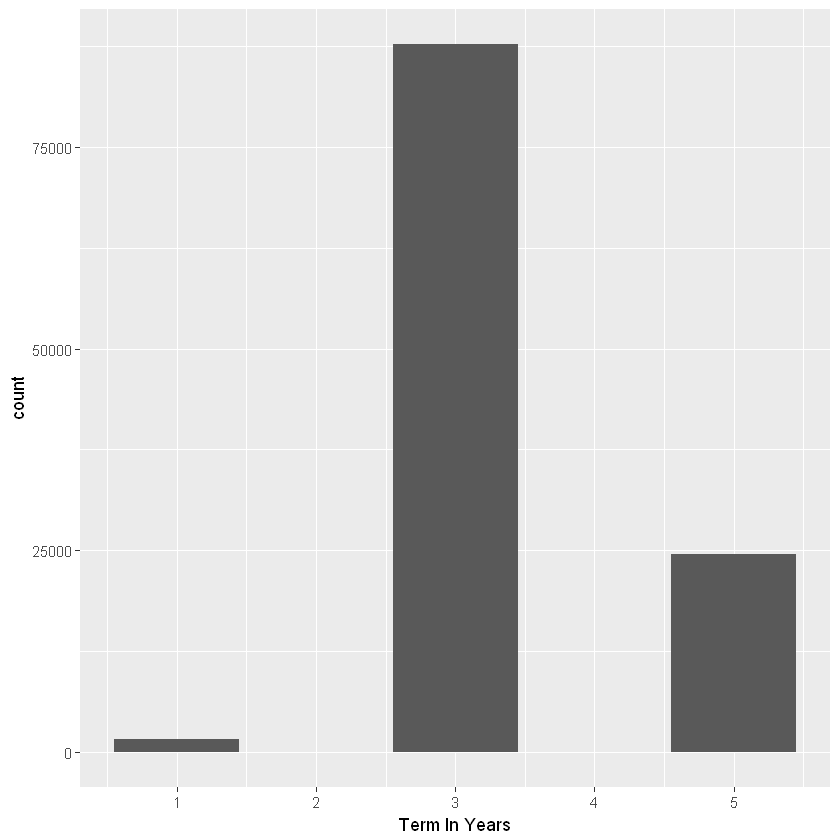

In [27]:
# Plot Term frequency in years.
ggplot(loans, aes(Term/12)) + geom_bar() + xlab("Term In Years")

Here we can see that term is discrete, and that 3 year loans far outpace 5 year loans, with 1 year loans coming in a distant third.

In [30]:
loans %>%
    group_by(Term) %>%
    summarise(count_per_term = n()) %>%
    mutate(percentage = count_per_term / sum(count_per_term) * 100)

Term,count_per_term,percentage
12,1614,1.416572
36,87778,77.040821
60,24545,21.542607


Here is the same information in a table with percentages.

## Loan Status 

In [31]:
summary(loans$LoanStatus)

Cancelled             Chargedoff              Completed 
                     5                  11992                  38074 
               Current              Defaulted FinalPaymentInProgress 
                 56576                   5018                    205 
  Past Due (>120 days)   Past Due (1-15 days)  Past Due (16-30 days) 
                    16                    806                    265 
 Past Due (31-60 days)  Past Due (61-90 days) Past Due (91-120 days) 
                   363                    313                    304

A quick note on definitions:  
Chargedoff - 
Via Investopedia.com "A charge-off or chargeoff is the declaration by a creditor (usually a credit card account) that an amount of debt is unlikely to be collected. This occurs when a consumer becomes severely delinquent on a debt. Traditionally, creditors will make this declaration at the point of six months without payment."  
  
Default  
"Default is the failure to pay interest or principal on a loan or security when due. Default occurs when a debtor is unable to meet the legal obligation of debt repayment ... When an individual, a business or even a nation defaults on a debt obligation, the lender or investor has some recourse to reclaim the funds, but it varies based on the type of security involved.



In [ ]:
ggplot(loans, aes(LoanStatus)) + geom_bar() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

Happily, the majority of the loans are either current or completed. If we were creating a model for this data it would likely be to predict if a new loan was going to become charged-of, defaulted, or past due. Cancelled, as we can see from our table, has just 5 loans. At this point I also reorder the factors so that the Past Due levels are in the correct order.

In [ ]:
#Plot the distribution of Past Due Loans
on_time_loans <- c('Cancelled', 'Completed', 'Chargedoff', 'Current','Defaulted','FinalPaymentInProgress')

past_due_loans <- loans %>%
filter(!LoanStatus %in% on_time_loans)
ggplot(past_due_loans, aes(LoanStatus)) + geom_bar() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

#adjusting x label source : http://tallman-world.tumblr.com/post/89964965867/rhow-to-rotate-axis-labels-in-ggplot2

Here we look at the distribution of Past Due loans.  
It seems that most loans that are past due are only 1-15 days past Due. This suggests that many of these loans are will become current again. I'm not sure if loans default or need to go through the whole 120 days. It is also worth noting that some of the bins here are larger than others, making the graph slightly misleading. (First two are 13 days, next three are 30.) 

In [ ]:
loans %>%
filter(LoanStatus == 'Cancelled') 

Seems that these are loans that started to be funded and then were cancelled. There are only 5 of them, and they all seem to have been closed less than a month after creation.

In [ ]:
######Add a new, simplified LoanStatus column called simple.LoanStatus
loans %>%
mutate(simple.LoanStatus = ifelse(str_detect(LoanStatus, "Past"), 'Past Due', as.character(LoanStatus)))%>%
filter(!str_detect(simple.LoanStatus, "Final")) %>%
filter(simple.LoanStatus != "Cancelled") %>%
ggplot(aes(simple.LoanStatus)) + geom_bar()

Our original LoanStatus bar chart had a bit too much going on, so above I have simplified it. This chart gives us a better idea of how many loans are past due.  

These LoanStatus' are intersting, but a lot depends on the data. Is this a snapshot of a month, a year? If this was for all time Completed and Defaulted will eventually become a huge part of the mix as the amount of loan history outpaces loans being originated. This distribution makes me think that it is a snapshot of a certain time frame, perhaps 4 years. 

In [ ]:
#Todo: Let's look at the origination dates to see if it gives us a clue.

## Borrower APR

In [ ]:
summary(loans$BorrowerAPR)

The Borrower APR is interesting to me in several ways. First off, there are people with incredible deals and terrible deals. Our minimum is .6% - that's a pretty great rate. I don't know anyone getting a rate that rate cheap outside of the Fed. On the other end there is someone paying 51% APR. Yikes. In some ways that probably means that's where the line is for risk. Prosper, or their lending partners, thinks there is a positive return on someone so risky you need to charge them over half the principal per year to loan it. 

In [ ]:
ggplot(loans, aes(BorrowerAPR)) + geom_histogram(bins=125)

Several intersting things there. First off it's almost a normal distribution, but it seems to have  spikes near round APR's, as well as a spike little bit under 30%. There is also a large spike at around 35%. This histogram is a little noisy, so let's look at a density plot.

In [ ]:
ggplot(loans, aes(BorrowerAPR)) + geom_density()
+ geom_segment(x=.2)

The peaks are easier to see with a density plot. But it is easy to see that a large amount of loans hover around 20% APR.

## BorrowerRate 

In [ ]:
summary(loans$BorrowerRate)

Here we notice that the rate is NOT the same thing as the APR. Looking at the definitions document we're simply told that the APR is the Annual Percentage Rate and that the Borrow's Rate is the borrower's interest rate for the loan. Some research tells us that these are calculated by:   

APR - Annual Percentage Rate. A percentage that represents the acutal yearly cost of funds over the term of the loan. Includes additional costs or fees but does not take compounding into account.  

Interest Rate - Refers only to the interst charged on the loan, doesn't take other expenses into acount. Therefore, APR tends to be higher than the loan's nominal interst rate. 

APY or EAR - Annual Percentage Yield or Effective Annual Rate takes compound interest into account. Tends to be larger than APR on the same loan.

As all of the above illustrates, APR can be a misleading indicator of actual costs. Some experts feel the APR is best used to compare long-term loans. Even with shorter-term debt, such as a seven-year note, the APR actually understates the cost of the loan. This is because APR calculations assume long-term repayment schedules; for loans that are repaid faster or have shorter repayment periods, the costs and fees are spread too thin with APR calculations. The average annual impact of closing costs is much smaller when those costs are assumed to have been spread over 30 years instead of seven to 10 years.


In [ ]:
ggplot(loans, aes(BorrowerRate)) + geom_bar(bins = 125)

## Estimated Effective Yield

In [ ]:
summary(loans$EstimatedEffectiveYield)

In [ ]:
ggplot(loans, aes(EstimatedEffectiveYield))+geom_histogram(bins=100)
#Why so many rows with non-finite values?

You can see that this distribution mimics the distribution of APR's but moved slightly lower, with some tail to the left as well. Let's see what's causing negative estimated yield loans.

In [ ]:
loans %>%
filter(EstimatedEffectiveYield < 0) %>%
summary()

#190 loans
#completed 146, chargedoff 42, defaulted, none current, this is not an estimation, nor does this variable really make 
#sense for them
#They didn't have rediculous APR's or anything.
#Could plot against estimated loss to see if there are different things going on here.
#time to close?

In [ ]:
loans %>%
filter(EstimatedEffectiveYield <0) %>%
filter (LoanStatus == 'Completed')
#Need to learn how to deal with dates in R.

Todo: Write about how this relates to the other yields. Perhaps group the Rates and the yields together. This could be one of the final visualizations - several density plots?

## ProsperScore

In [ ]:
summary(loans$ProsperScore)
ggplot(loans, aes(ProsperScore)) + geom_histogram()

Here you can see that ProsperScore is discrete, and potentially bimodal? Strange clustering between 4 and 5, let's look at unique values.

In [ ]:
sort(unique(loans$ProsperScore))

1 to 11? That's a strange scale for scoring. Maybe it's analogous to 0 to 10, but they don't want to make people feel bad by giving them 0's.

In [ ]:
table(loans$ProsperScore)

## Listing Category

In [ ]:
loans %>%
group_by(ListingCategory) %>%
summarise(count = n()) %>%
ggplot(aes(x=reorder(ListingCategory, desc(count)), y=count)) + 
geom_bar(stat="Identity") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))

It looks like Debt Consolidation is the most popular reason to apply for a loan. 

In [ ]:
loans %>%
group_by(BorrowerState) %>%
summarise(count = n()) %>%
ggplot(aes(x=reorder(BorrowerState, desc(count)), y=count)) + 
geom_bar(stat="Identity") +
theme(text = element_text(size=8))
#SOMEDAY:choropleth here?

This bar chart doesn't actually tell us much because we would have to weight these by the population of each state to see if there are real differences between them.

## Occupation

In [ ]:
loans %>% 
group_by(Occupation) %>%
filter(Occupation != "") %>%
summarise(count = n()) %>%
arrange(desc(count)) %>%
filter(count > 3000)

Again, to see if any occupation actually had an undue number of loans we would have to get an estimate of how many people had each job in the population. Still, categorical variables like this are always interesting to look at since they put a human face on our data. 

## Employment Status

In [ ]:
loans %>%
group_by(EmploymentStatus) %>%
summarise(count=n()) %>%
arrange(desc(count))

Oh, so many questions here.  
Are some of these categories subsets of other categories? (ie Does 'Employed = Full-time+Part-Time+Self Employed"? Let's try to find out.

In [ ]:
unique(loans$EmploymentStatus)

In [ ]:
loans %>% 
filter(EmploymentStatus %in% c('Self-employed','Full-time','Part-time')) %>%
count()

loans %>%
filter(EmploymentStatus == 'Employed') %>%
count()

Even with the addition of 'Other' and the NULLs the categories would not approach the number of employment. Not really into this categorical variable.

## EmploymentStatusDuration

In [ ]:
summary(loans$EmploymentStatusDuration)

In [ ]:
ggplot(loans, aes(EmploymentStatusDuration)) + geom_histogram()

In [ ]:
summarise(loans, status.mean = mean(EmploymentStatusDuration, na.rm=TRUE)/12,
         status.median = median(EmploymentStatusDuration, na.rm = TRUE)/12,
         status.min = min(EmploymentStatusDuration, na.rm = TRUE)/12,
         status.max = max(EmploymentStatusDuration, na.rm = TRUE)/12)
#todo

Looks like someone claims to have worked somewhere for almost 63 years! Maybe they're saying the've been employed for 63 years straight.

## Credit Score

Credit Range Upper and Lower. I would like to know the spread within each person, and the variance of that spread. Is this the same as Mean Upper - Mean Lower?

In [ ]:
creditScoreUpper <- loans$CreditScoreRangeUpper
creditScoreLower <- loans$CreditScoreRangeLower

In [ ]:
head(creditScoreUpper)

In [ ]:
ggplot(loans, aes(CreditScoreRangeUpper)) + 
geom_histogram(binwidth=5) + 
coord_cartesian(xlim=c(450,900))
#Zooming in to take because Credit Score of 0 ruins scale of histogram.

The two bumps in credit score here remind me of the bumps in APR/Rate. I'm sure there is a correlation there - more people with the same credit score more people with the same rate. I wonder how Prosper comes up with their score, is it just Fico or something more? Also it would be interesting to see what credit score distribution looks like in the general population.

In [ ]:
ggplot(loans, aes(CreditScoreRangeLower)) + 
geom_histogram(binwidth=5) + 
coord_cartesian(xlim=c(450,900))
#Zooming in to take because Credit Score of 0 ruins scale of histogram.

In [ ]:
#Todo: Would like to plot these one over another.

It's easy to see that the Upper Range and Lower range of the credit score have the same distribution shifted on the X axis.

## Lender Yield

In [ ]:
#Lender Yield
summary(loans$LenderYield)

In [ ]:
ggplot(loans, aes(LenderYield)) + geom_histogram(binwidth = .01)

The same spike that exists in the other Rate plots exists her at around 30%. Hard to know if this is a pricing strategy, or a rate that is popular for other reasons. It is roughly equivalent to a credit card. The max is slightly under the max borrower rate, so fees paid to Prosper must not be included in this number.

## Income Range

In [ ]:
loans$IncomeRange <- factor(loans$IncomeRange, levels = c('$0', '$1-24,999', '$25,000-49,999', 
                                                            '$50,000-74,999', '$75,000-99,999',  
                                                            '$100,000+', 'Not displayed', 'Not employed'))

In [ ]:
loans %>%
filter(!IncomeRange %in% c('Not displayed', 'Not employed')) %>%
ggplot(aes(IncomeRange)) + geom_bar() +
theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
#Todo: investigate loans made to people with $0 income.

## Income Verifiable

In [ ]:
ggplot(loans, aes(IncomeVerifiable)) + geom_bar()

Looks like most loans go to people with verifiable incomes. Todo:
Wonder what the non-verified loans look like, and what the distribution of IncomeRanges changes to. 

## Monthly Loan Payment

In [ ]:
summary(loans$MonthlyLoanPayment)

In [ ]:
monthly_payment <- ggplot(loans, aes(MonthlyLoanPayment)) + geom_histogram(bins=50)
monthly_payment

Looks like there's a big outlier there with our max  22252. But our histogram makes it hard to see this. Let's zoom in on the bulk of the payments.

In [ ]:
monthly_payment + coord_cartesian(c(0,1250))

After 200 there is a sharp drop off in monthly payments. This may be related to my binwidth. We might be able to calculate this payment from other variables. Principal + Interest / Term.

## Loan Original Amount

In [ ]:
summary(loans$LoanOriginalAmount)
ggplot(loans, aes(LoanOriginalAmount)) + geom_histogram(bins=100)
#how could I mike the bins seperate by 500's or 100's?

We can see that Loan Amounts tend to be in whole numbers. Let's see the most common loan amounts.

In [ ]:
loans %>%
group_by(LoanOriginalAmount) %>%
summarise(count = n()) %>%
filter(count > 3000) %>%
arrange(desc(count))

## Percent Funded

In [ ]:
summary(loans$PercentFunded)
ggplot(loans, aes(PercentFunded)) + geom_histogram()

OK, so it looks like the vast percentage were 100% funded (or they probably wouldn't be in this dataset!) Let's take a closer look at those that weren't.  
Also, it looks like minimally 70% of the loans in the set were funded. Maybe that is Prosper's cutoff?

In [ ]:
loans %>%
filter(PercentFunded < 1) %>%
ggplot(aes(PercentFunded)) + geom_histogram(bins=30)

The only thing I see for sure here is that of the loans that do not get 100% funded, many are 70% funded, and the amount at each precentage from 70-99% trends downward until it hits 100%, where most of the loans reside. Tis could be interprested as the higher your funding percentage the more likely you are to be funded 100%.

In [ ]:
loans %>%
filter(PercentFunded < 1) %>%
ggplot(aes(PercentFunded)) + geom_density()

## Number of Investors

In [ ]:
summary(loans$Investors)

Should be related to the size of the loan.

In [ ]:
ggplot(loans, aes(Investors)) + geom_histogram(bins=100)

Wow, in a a platform that lets you pool your risk with other investors, a vast majority of loans still only have 1 investor.

In [ ]:
loans %>%
group_by(Investors) %>%
summarise(count = n()) %>%
filter(Investors <= 5)

In [ ]:
#for multivariate - Investors vs Loan Amount

# Multivariate Exploration

## Term and APR

1 - Term 
#####LoanStatus = Need tto group loans efffectively first
BorrowerAPR
Estimated Effective Yield / Yield would have had
#####Income Range
#####Loan Amount

In [ ]:
ggplot(loans, aes(group=Term, x=Term/12, y=BorrowerAPR)) + geom_boxplot()

In [ ]:
ggplot(loans, aes(group=Term, x=Term/12, y=LenderYield)) + geom_boxplot()

Well that's interesting, but in hindsight pretty obvious. Though the median(?) Borrower APR stays flat over the three terms, the expect yield increases. That makes sense though, seeing that given 2 loans of the same amount with the same APR the one with the longer term will have a higgher yield. (More payments, more time to collect interest, etc.

In [ ]:
#Let's look at the same thing for Estimated Effective Yield
ggplot(loans, aes(group=Term, x=Term/12, y=EstimatedEffectiveYield)) + geom_boxplot()

The term's relationship to one another stay static, but there are a bunch of outliers with negative Estimated Effective Yield, and only in the 3 year term. Let's take a look atht those loans.

In [ ]:
negativeExpectedYield <- loans %>%
filter(EstimatedEffectiveYield <= 0)

In [ ]:
negativeExpectedYield

The first thing that jumps out is that they are all either completed or Charged off. Perhaps the completed ones were paid early, and with fees their yield bacome negative? Chargedoff Loans the lender is losting out on , period - by why do they seem so prevalent in the middle term?

In [ ]:
summary(negativeExpectedYield)

147 Completed, 42 Charged off in this subset. Definitely want to take a closer look at the completed.
Median borrower APR: .28902
Todo: Difference between Rate and APR
EstimatedLoss : would also be good to look at. Median .345
Can look at their prosperScores. 
Occpation: 'Other' is way out in front. Is this due to a high portion of the pop nbnot having one of the listed jobs?
Credit is confusing here because this group also contains complete, likely paid off early loans.
WOnder if I could find 'the most ridiculous loan issued?
Income Range of Charged off Loans. 
Income Verified?
Propser Principal Borrowed - didnt even know about this variable.
ProsperPrincipal Outstanding
LoanFirstDefaultedCycleNumber
LoanMonthsSinceOrigination
Loan Original Amount - how is this different from ProsperPrincipalBorrowed?
LPCustomerPrincipalPayments

In [ ]:
#The question is: does a person's income affect the term of the loan they take out.
#put all the names of the income groups in a vector
summary(loans$IncomeRange) #to check names

In [ ]:
levels(loans$IncomeRange)

In [ ]:
loans$IncomeRange <- factor(loans$IncomeRange, levels = c("$0", "$1-24,999", "$25,000-49,999", "$50,000-74,999", 
                                                            "$100,000+", "Not displayed", "Not employed"))

In [ ]:
dim(loans)
with_income_info <- loans %>%
filter(!IncomeRange %in% c('Not displayed','Not employed'))
dim(with_income_info)

In [ ]:
#makes sense to use percentage here, or comparing apples to oranges.
#So that is Count of Income Using that Term / Count of People with that Income
income_facet <- ggplot(with_income_info, aes(Income Range)) + geom_bar()

In [ ]:
ggplot(with_income_info, aes(Term, fill=IncomeRange)) + geom_bar(position="dodge") 

In [ ]:
#plotting term count grouped by incomerange, income range with term 
p <- with_income_info %>% group_by(IncomeRange) %>% count(Term) %>% arrange(IncomeRange, Term)
ggplot(p, aes(Term))+geom_bar()
#this deffinitely creates the right table - need to figure out how to plot it
#might have to add 12 mo term to 0
#OK - so doesn't like trying to plot 'objects of type grouped'. can i ungroup them or r
#coerce them into being something else/

In [ ]:
ggplot(with_income_info, aes(Term)) + geom_bar() + facet_wrap(~IncomeRange)

#these graphs are still deficient because they're absolute, not perncentage /density

In [ ]:
#for each income bucket, what percentage of loans are which term
loans %>%
filter(IncomeRange )
group_by(IncomeRange, Term) %>%
summarise(number_of_loans = n()) %>%
mutate(freq = number_of_loans / sum(number_of_loans)) 


In [ ]:
#for each income bucket, what percentage of loans are whic term
loans %>%
select(ListingKey, Term, IncomeRange) %>%
group_by(IncomeRange) %>%
mutate(number_of_loans = n()) %>%
group_by(Term) %>%
summarize(percentage_term = n())